In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import pylab as plb
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
import plotfuncs as plf
plb.rcParams['pdf.fonttype'] = 42
plb.rcParams['image.interpolation'] = 'nearest'
plb.rcParams['image.aspect'] = 'auto'
plb.rcParams['image.cmap'] = 'BrBG'
import h5py
demo_mode = False

In [2]:
filter_mode = 'non_linear'

In [4]:
saccade_tables_39E01 = h5py.File('detected_saccades_nl_39E01.hdf5','r')
saccade_tables_22H05 = h5py.File('detected_saccades_nl.hdf5','r')

In [17]:
#sort_sig = saccade_tables['filtered'][:,20]
sort_sig_22H05 = np.mean(saccade_tables_22H05['Ph1'][:,49:51],axis = 1) - np.mean(saccade_tables_22H05['Ph1'][:,:30],axis = 1)
sort_sig_39E01 = np.mean(saccade_tables_39E01['Ph1'][:,49:51],axis = 1) - np.mean(saccade_tables_39E01['Ph1'][:,:30],axis = 1)

In [18]:
sort_idx_22H05 = np.argsort(sort_sig_22H05,axis = 0)
sort_idx_39E01 = np.argsort(sort_sig_39E01,axis = 0)

In [19]:
#plb.imshow(np.array(saccade_tables['filtered'])[sort_idx,:],aspect='auto',vmin = -4,vmax = 4)

In [20]:
#create dict of sorted trials in memory
sorted_saccades_22H05 = dict()
[sorted_saccades_22H05.update({sig:np.array(saccade_tables_22H05[sig])[sort_idx_22H05]}) for 
                                                sig in saccade_tables_22H05.keys()];
sorted_saccades_39E01 = dict()
[sorted_saccades_39E01.update({sig:np.array(saccade_tables_39E01[sig])[sort_idx_39E01]}) for 
                                                sig in saccade_tables_39E01.keys()];

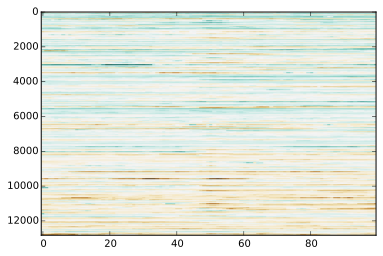

In [21]:
plb.imshow(saccade_tables_22H05['Ph0'])

### first look at the saccade triggered averages - broken into desciles according to response magnitude

In [54]:
sorted_saccades_22H05.keys()

[u'rwing_mean',
 u'fly_numbers',
 u'i1',
 u'lwing_mean',
 u'i2',
 u'xi',
 u'b1',
 u'b2',
 u'b3',
 u'lwing_norm',
 u'rwing_norm',
 u'trial_names',
 u'row',
 u'filtered',
 u'iii1',
 u'hg4',
 u'hg2',
 u'hg3',
 u'peak',
 u'hg1',
 u'lmr_norms',
 u'Ph2',
 u'Ph1',
 u'Ph0',
 u'iii24',
 u'iii3',
 u'lmr_mean']

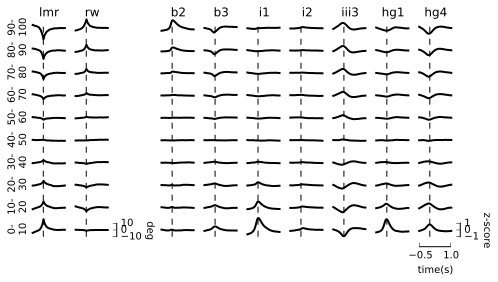

In [65]:
#signals to plot
trace_keys = ['Ph2','Ph1','','b2','b3','i1','i2','iii3','hg1','hg4']
#break up the saccade responses by desciles
quantile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],11).astype(int)[::-1]
quantile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],11).astype(int)[::-1]

def show_saccade_quantile_ca(col,row):
    """plot function for saccade quantile plots"""
    if col == 2:
        return
    if col<7:
        sorted_saccades = sorted_saccades_22H05
        quantile_ranges = quantile_ranges_22H05
    else:
        sorted_saccades = sorted_saccades_39E01
        quantile_ranges = quantile_ranges_39E01

    range_start = quantile_ranges[row+1]
    range_stop = quantile_ranges[row]
    if col == 0:
        data_chunk = np.array(sorted_saccades[trace_keys[col]][range_start:range_stop,:])
        norms = np.array(sorted_saccades['lmr_norms'][range_start:range_stop])
        data_chunk *= norms[:,None]
        data_chunk -= np.mean(data_chunk,axis = 1)[:,np.newaxis]
        data_chunk = gd.signal_plot_info['Ph2']['transform'](data_chunk)
        data_chunk /= 10.0
    if col == 1:
        data_chunk = np.array(sorted_saccades[trace_keys[col]][range_start:range_stop,:])
        norms = np.array(sorted_saccades['rwing_norm'][range_start:range_stop])
        data_chunk *= norms[:,None]
        data_chunk -= np.mean(data_chunk,axis = 1)[:,np.newaxis]
        data_chunk = gd.signal_plot_info['Ph1']['transform'](data_chunk)
        data_chunk /= 10.0
    else:
        data_chunk = np.array(sorted_saccades[trace_keys[col]][range_start:range_stop,:])
        data_chunk -= np.mean(data_chunk,axis = 1)[:,np.newaxis]
    x = np.linspace(-50*.021,50*.021,np.shape(data_chunk)[1])[25:]
    y = np.nanmean(data_chunk,axis = 0)[25:]
    plb.plot(x, y,'k',lw = 2,clip_on = False)

rows = 10
cols = len(trace_keys)
show_spines_right = [False]*rows;show_spines_right[-1] = True
show_spines_bottom = [False]*cols;show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'time(s)'
row_labels_right = [None]*rows;row_labels_right[-1] = 'z-score'
row_labels_left = ['%s-\n%s'%(p) for p in zip(range(90,-10,-10),range(100,0,-10))]
import copy as cp
col_labels_top =  cp.copy(trace_keys)

col_labels_top[0] = 'lmr';
col_labels_top[1] = 'rw';
#col_labels_top[6] = 'lmr';
#col_labels_top[7] = 'rw';
col_axvlines = [0]*cols
col_axvlines[2] = None
ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = show_saccade_quantile_ca,
                                  figsize = (7,4.0),
                                  xbounds = (-0.5,1),
                                  ybounds = (-1,1),
                                  row_labels_left = row_labels_left,
                                  row_labels_right = row_labels_right,
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  col_axvlines = col_axvlines,
                                  col_axvlines_kwargs = {'color':'k','ls':'--'},
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom)
plb.sca(ax_grid[-1][1])
plb.gca().spines['right'].set_visible(True)
plb.gca().spines['right'].set_position(('outward',10))
[x.set_visible(True) for x in plb.gca().get_yticklines()]
plb.gca().tick_params(right = True,
                      left = False,
                      labelleft = False,
                      labelright = True)
plb.yticks([-10,0,10])
plb.gca().yaxis.set_label_position("right")
plb.gca().set_ylabel('deg',rotation = -90,va = 'bottom')
plb.draw()
#plb.savefig('STAs_desciles_39E01.pdf')

### How does the mean emerge from the single trial data - look at rasters for the two larger desciles, it appears that in some muscles saccade magnitude is reflected by changes in the probability of responses.

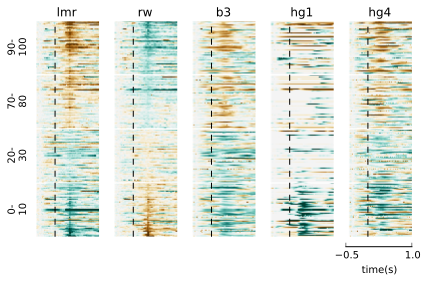

In [24]:
#trace_data = [traces_lmr,traces_rw,traces_b2,traces_b3,traces_i1]
trace_keys = ['Ph2','Ph1','b3','hg1','hg4']

quantile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],11).astype(int)[::-1]
quantile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],11).astype(int)[::-1]

def show_saccade_img(col,row):
    """plot function for saccade quantile plots"""
    imdx = 30
    if row == 0:
        range_start = quantile_ranges_39E01[1]
        range_stop = quantile_ranges_39E01[0]
    if row == 1:
        range_start = quantile_ranges_39E01[3]
        range_stop = quantile_ranges_39E01[2]
    if row == 2:
        range_start = quantile_ranges_39E01[-3]
        range_stop = quantile_ranges_39E01[-4]
    if row == 3:
        range_start = quantile_ranges_39E01[-1]
        range_stop = quantile_ranges_39E01[-2]

    data_chunk = np.array(sorted_saccades_39E01[trace_keys[col]][range_start:range_stop,:])
    data_chunk -= np.mean(data_chunk[:,:10],axis = 1)[:,np.newaxis]
    plb.imshow(data_chunk[::imdx][::-1],
       aspect = 'auto',interpolation = 'nearest',
       vmin =-3,vmax = 3,
       extent = [-20*.021,50*.021,-4,4],
       cmap = plb.cm.BrBG)

rows = 4
cols = 5

show_spines_right = [False]*rows;show_spines_right[0] = True
show_spines_bottom = [False]*cols;show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'time(s)'
row_labels_left = ['%s-\n%s'%(p) for p in [(90,100),(70,80),(20,30),(0,10)]]
col_labels_top = ['lmr','rw','b3','hg1','hg4']

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = show_saccade_img,
                                  figsize = (6.0,4.0),
                                  xbounds = (-.5,1),
                                  ybounds = (-4,4),
                                  row_labels_left = row_labels_left,
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  show_spines_right = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_bottom = show_spines_bottom)
[ax.set_zorder(np.inf) for ax in col_epoch_panels]
#plb.show()
plb.savefig('STAs_extrema_rasters_39E01.pdf')

### to quantify this effect I made histograms of the response magnitude this time broken down in 5 percentile brackets

In [25]:
demo_mode = False

In [26]:
if not(demo_mode):
    signals_to_search = ['Ph2','Ph1','b1','b2','b3','i1','i2','hg1','hg4']

    percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
    top30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[5:35:5],percentile_ranges_22H05[0:30:5])
    bottom30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[74:105:5],percentile_ranges_22H05[70:100:5])
    bw_search = list()

    from sklearn.neighbors import KernelDensity
    from sklearn.grid_search import GridSearchCV

    for bracket in range(6):
        range_start,range_stop = top30_percentile_brackets[bracket]
        for sig in signals_to_search:
            data_chunk = np.array(sorted_saccades[sig][range_start:range_stop,:])
            X = np.mean(data_chunk[:,49:51],axis = 1)[:, np.newaxis]
            grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(0.1, 1.0, 30)},
                        cv=20) # 20-fold cross-validation
            grid.fit(X)
            bw =  grid.best_params_['bandwidth']
            bw_search.append(bw)

    for bracket in range(6):
        range_start,range_stop = top30_percentile_brackets[bracket]
        for sig in signals_to_search:
            print sig
            data_chunk = np.array(sorted_saccades[sig][range_start:range_stop,:])
            X = np.mean(data_chunk[:,49:51],axis = 1)[:, np.newaxis]
            grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(0.1, 1.0, 30)},
                        cv=20) # 20-fold cross-validation
            grid.fit(X)
            bw =  grid.best_params_['bandwidth']
            bw_search.append(bw)
    bandwidth = np.mean(bw_search)        
    print np.mean(bw_search)
else:
    percentile_ranges = np.linspace(0,np.shape(sorted_saccades['Ph2'])[0],100).astype(int)[::-1]
    top30_percentile_brackets = zip(percentile_ranges[5:35:5],percentile_ranges[0:30:5])
    bottom30_percentile_brackets = zip(percentile_ranges[74:105:5],percentile_ranges[70:100:5])
    bandwidth = 0.365862068966

NameError: name 'top30_percentile_brackets' is not defined

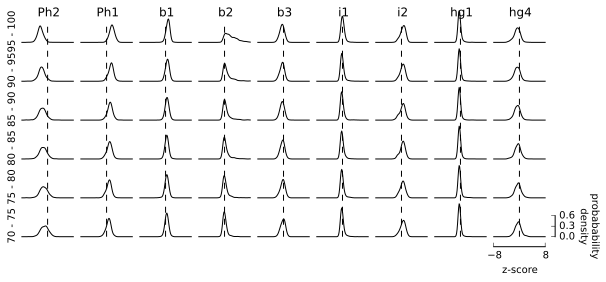

In [ ]:
reload(plf)
trace_keys = ['Ph2','Ph1','b1','b2','b3','i1','i2','hg1','hg4']

bandwidth = 0.365862068966

percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
top30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[5:35:5],percentile_ranges_22H05[0:30:5])
bottom30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[74:105:5],percentile_ranges_22H05[70:100:5])

percentile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],100).astype(int)[::-1]
top30_percentile_brackets_39E01 = zip(percentile_ranges_39E01[5:35:5],percentile_ranges_39E01[0:30:5])
bottom30_percentile_brackets_39E01 = zip(percentile_ranges_39E01[74:105:5],percentile_ranges_39E01[70:100:5])

def get_kde(data_chunk):
    from sklearn.neighbors import KernelDensity
    X = np.mean(data_chunk[:,49:51],axis = 1)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
    X_plot = np.linspace(-8, 8, 100)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    return X_plot,np.exp(log_dens)

def plot_top30_percentiles(col,row):
    if col < 7:
        range_start,range_stop = top30_percentile_brackets_22H05[row]
        data_chunk = sorted_saccades_22H05[trace_keys[col]][range_start:range_stop,:]
    else:
        range_start,range_stop = top30_percentile_brackets_39E01[row]
        data_chunk = sorted_saccades_39E01[trace_keys[col]][range_start:range_stop,:]
    plb.plot(*get_kde(data_chunk),color = 'k',clip_on = False)
    
def plot_bottom30_percentiles(col,row):
    if col < 7:
        range_start,range_stop = bottom30_percentile_brackets_22H05[row]
        data_chunk = sorted_saccades_22H05[trace_keys[col]][range_start:range_stop,:]
    else:
        range_start,range_stop = bottom30_percentile_brackets_39E01[row]
        data_chunk = sorted_saccades_39E01[trace_keys[col]][range_start:range_stop,:]
    plb.plot(*get_kde(data_chunk),color = 'k',clip_on = False)

rows = 6
cols = len(trace_keys)
show_spines_right = [False]*rows; show_spines_right[-1] = True
show_spines_bottom = [False]*cols; show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'z-score'
row_labels_right = [None]*rows;row_labels_right[-1] = 'probabability \ndensity'

col_labels_top =  cp.copy(trace_keys)

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = plot_top30_percentiles,
                                  figsize = (8.5,4),
                                  xbounds = (-8,8),
                                  ybounds = (0,0.6),
                                  row_labels_left = ['%s - %s'%(p) for 
                                                     p in zip(range(70,100,5),range(75,105,5))[::-1]],
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom,
                                  row_labels_right = row_labels_right)
plb.savefig('STA_kde_top30_39E01.pdf')

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = plot_bottom30_percentiles,
                                  figsize = (8.5,4),
                                  xbounds = (-8,8),
                                  ybounds = (0,0.6),
                                  row_labels_left = ['%s-%s'%(p) for 
                                                     p in zip(range(0,30,5),range(5,35,5))[::-1]],
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom,
                                  row_labels_right = row_labels_right)
plb.savefig('STA_kde_bottom30_39E01.pdf')

In [106]:
range_start,range_stop_ = bottom30_percentile_brackets_22H05[-1]
range_start_,range_stop = bottom30_percentile_brackets_22H05[-4]
data_chunk = sorted_saccades_22H05['i1'][range_start:range_stop,:]

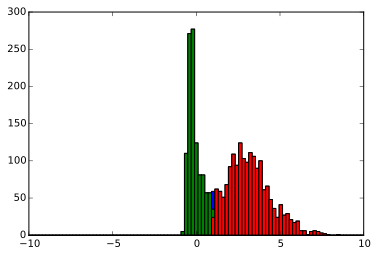

In [107]:
idx_rng = np.arange(0,len(sorted_saccades_22H05['i1']))
range_mask = (idx_rng > range_start) & (idx_rng < range_stop)
mag_mask_low = sorted_saccades_22H05['i1'][:,20] < 1.0
mag_mask_high = sorted_saccades_22H05['i1'][:,20] > 1.0
plb.hist(sorted_saccades_22H05['i1'][range_mask][:,20],bins = np.linspace(-10,10,100))
plb.hist(sorted_saccades_22H05['i1'][range_mask & mag_mask_low][:,20],bins = np.linspace(-10,10,100))
lns = plb.hist(sorted_saccades_22H05['i1'][range_mask & mag_mask_high][:,20],bins = np.linspace(-10,10,100))

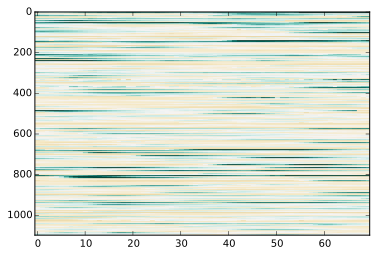

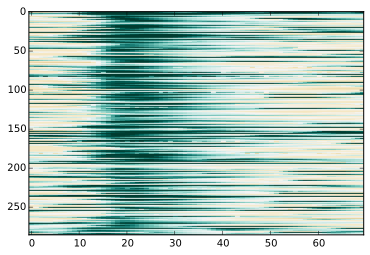

In [108]:
plb.imshow(sorted_saccades_22H05['hg1'][range_mask & mag_mask_low],vmin = -3,vmax = 3)
plb.figure()
plb.imshow(sorted_saccades_22H05['hg1'][range_mask & mag_mask_high][::6],vmin = -3,vmax = 3)

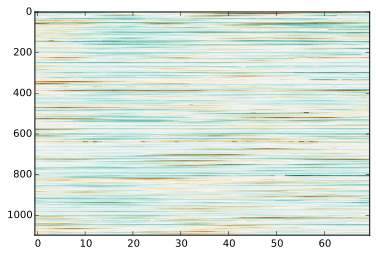

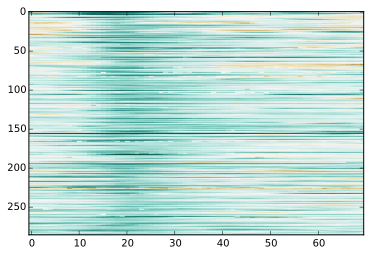

In [109]:
plb.imshow(sorted_saccades_22H05['b3'][range_mask & mag_mask_low],vmin = -3,vmax = 3)
plb.figure()
plb.imshow(sorted_saccades_22H05['b3'][range_mask & mag_mask_high][::6],vmin = -3,vmax = 3)

In [46]:
#plb.plot(sorted_saccades_22H05['b3'][:,20],
#         sorted_saccades_22H05['Ph1'][:,20],'o')

#plb.plot(sorted_saccades_22H05['b3'][range_mask ][:,20],
#         sorted_saccades_22H05['Ph1'][range_mask ][:,20],'o')
#plb.plot(sorted_saccades_22H05['b3'][range_mask & mag_mask_low][:,20],
#         sorted_saccades_22H05['Ph1'][range_mask & mag_mask_low][:,20],'o')

In [147]:
?plb.fill_between

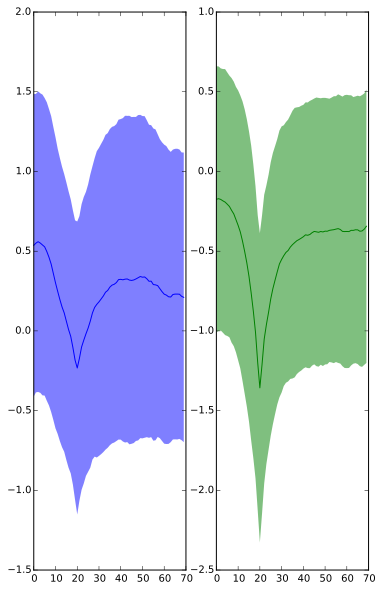

In [159]:
plb.figure(figsize = (6,10))
plb.subplot(1,2,1)
mn = np.mean(sorted_saccades_22H05['Ph1'][range_mask & mag_mask_low],axis = 0)
ub = mn + np.std(sorted_saccades_22H05['Ph1'][range_mask & mag_mask_low],axis = 0)
lb = mn - np.std(sorted_saccades_22H05['Ph1'][range_mask & mag_mask_low],axis = 0)

plb.fill_between(np.arange(len(mn)),ub,lb,alpha = 0.5,edgecolor = 'none')
plb.plot(np.arange(len(mn)),mn,color = 'b')
#plb.plot(np.mean(sorted_saccades_22H05['Ph1'][range_mask & mag_mask_low],axis = 0) +
#         np.std(sorted_saccades_22H05['Ph1'][range_mask & mag_mask_low],axis = 0))
plb.subplot(1,2,2)

mn = np.mean(sorted_saccades_22H05['Ph1'][range_mask & mag_mask_high],axis = 0)
ub = mn + np.std(sorted_saccades_22H05['Ph1'][range_mask & mag_mask_high],axis = 0)
lb = mn - np.std(sorted_saccades_22H05['Ph1'][range_mask & mag_mask_high],axis = 0)

plb.fill_between(np.arange(len(mn)),ub,lb,alpha = 0.5,edgecolor = 'none',facecolor = 'g')
plb.plot(np.arange(len(mn)),mn,color = 'g')

In [160]:
70*0.021

1.4700000000000002

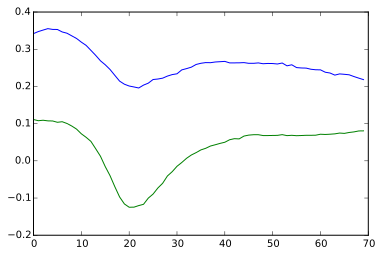

In [113]:
plb.plot(np.mean(sorted_saccades_22H05['b1'][range_mask & mag_mask_low],axis = 0))
plb.plot(np.mean(sorted_saccades_22H05['b1'][range_mask & mag_mask_high],axis = 0))

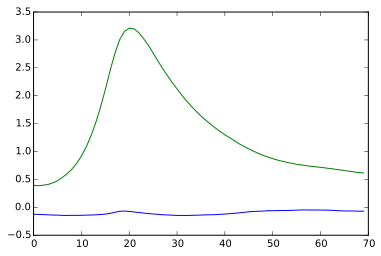

In [112]:
plb.plot(np.mean(sorted_saccades_22H05['i1'][range_mask & mag_mask_low],axis = 0))
plb.plot(np.mean(sorted_saccades_22H05['i1'][range_mask & mag_mask_high],axis = 0))

In [114]:
for nm in set(sorted_saccades_22H05['trial_names']):
    print gd.trial_to_label[nm]
    success = np.sum(sorted_saccades_22H05['trial_names'][range_mask & mag_mask_high & stim_mask] == nm)
    fail = np.sum(sorted_saccades_22H05['trial_names'][range_mask & mag_mask_low & stim_mask] == nm)
    print fail/float(success)

BCK
0.522388059701
YR
0.469026548673
YL
1.20408163265
DES
1.80952380952
FOR
0.54
ASC
0.969696969697


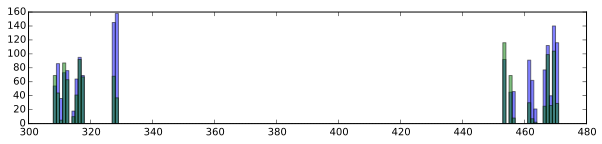

In [176]:
plb.figure(figsize = (10,2))
lns = plb.hist(sorted_saccades_22H05['fly_numbers'][range_mask & mag_mask_high],bins = np.arange(300,480),alpha = 0.5)
lns = plb.hist(sorted_saccades_22H05['fly_numbers'][range_mask & mag_mask_low],bins = np.arange(300,480),alpha = 0.5)

In [86]:
xi = gd.get_xio('yaw_left')

In [92]:
sstart = np.argwhere((xi<3) & (xi>0))[0]
send = np.argwhere((xi<3) & (xi>0))[-1]
stim_mask = (sorted_saccades_22H05['peak'] > sstart) & (sorted_saccades_22H05['peak'] > send)